In [2]:
import numpy as np
import random as rnd
import pandas as pd
import random

from deap import base
from deap import creator
from deap import tools

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline

In [61]:
df = pd.DataFrame(seaborn.load_dataset('titanic'))

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [62]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [63]:
median = df["age"].median()
df["age"] = df["age"].fillna(median)
df["age"].isnull().sum()

0

In [64]:
print(df["embarked"].value_counts())
df["embarked"] = df["embarked"].fillna("S")
df["embarked"].isnull().sum()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64


0

In [65]:
print(df["embark_town"].value_counts())
df["embark_town"] = df["embark_town"].fillna("Southampton")
df["embark_town"].isnull().sum()

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64


0

In [66]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64

In [67]:
features = ["sex", "embarked", "class",
            "who", "adult_male", "embark_town", "alone"]

for feature in features:
  le = preprocessing.LabelEncoder()
  le = le.fit(df[feature])
  df[feature] = le.transform(df[feature])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    int64   
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    int64   
 8   class        891 non-null    int64   
 9   who          891 non-null    int64   
 10  adult_male   891 non-null    int64   
 11  deck         203 non-null    category
 12  embark_town  891 non-null    int64   
 13  alive        891 non-null    object  
 14  alone        891 non-null    int64   
dtypes: category(1), float64(2), int64(11), object(1)
memory usage: 98.8+ KB


In [68]:
selected_columns = []
for col in df.columns:
  if (df[col].dtype == 'int64' or df[col].dtype == 'int32' or df[col].dtype == 'float64' or df[col].dtype == 'uint8'):
    selected_columns.append(col)

df = df.loc[:, selected_columns]
df.head()
selected_columns.remove("survived")

print(df.describe())

         survived      pclass         sex         age       sibsp       parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.647587   29.361582    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.019697    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    1.000000   28.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             fare    embarked       class         who  adult_male  \
count  891.000000  891.000000  891.000000  891.000000  891.000000   
mean    32.204208    1.536476    1.308642    1.210999    0.602694   
std     49.693429    0.791503    0.836071    0.594291    0.4896

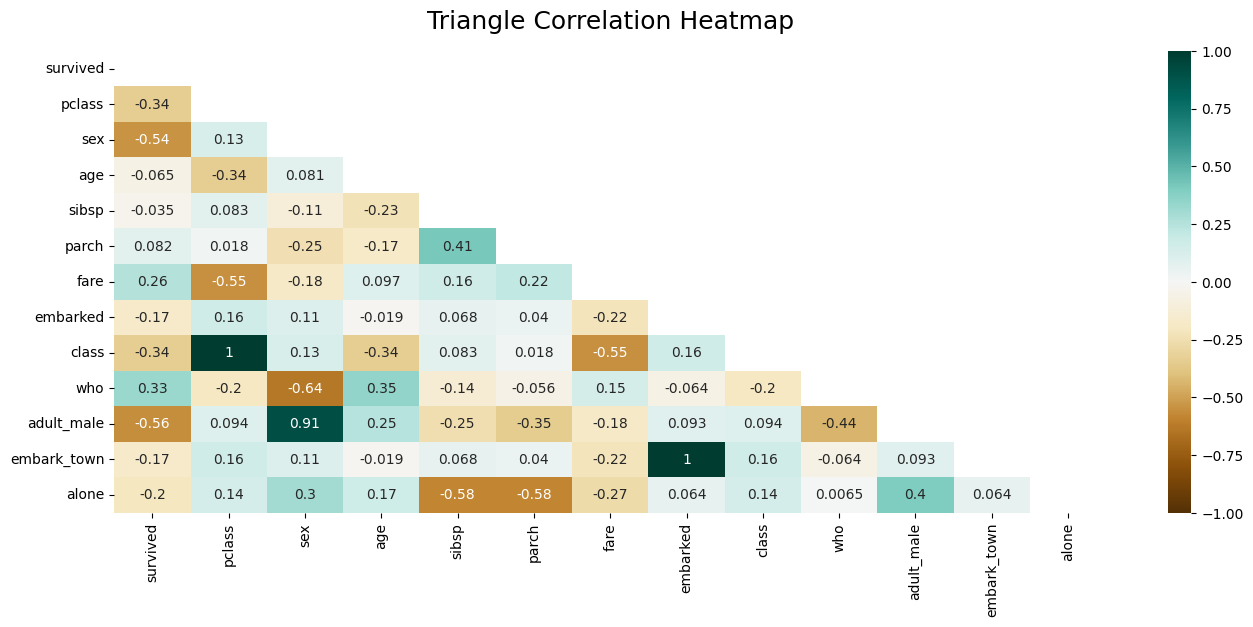

In [69]:
# plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool_))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

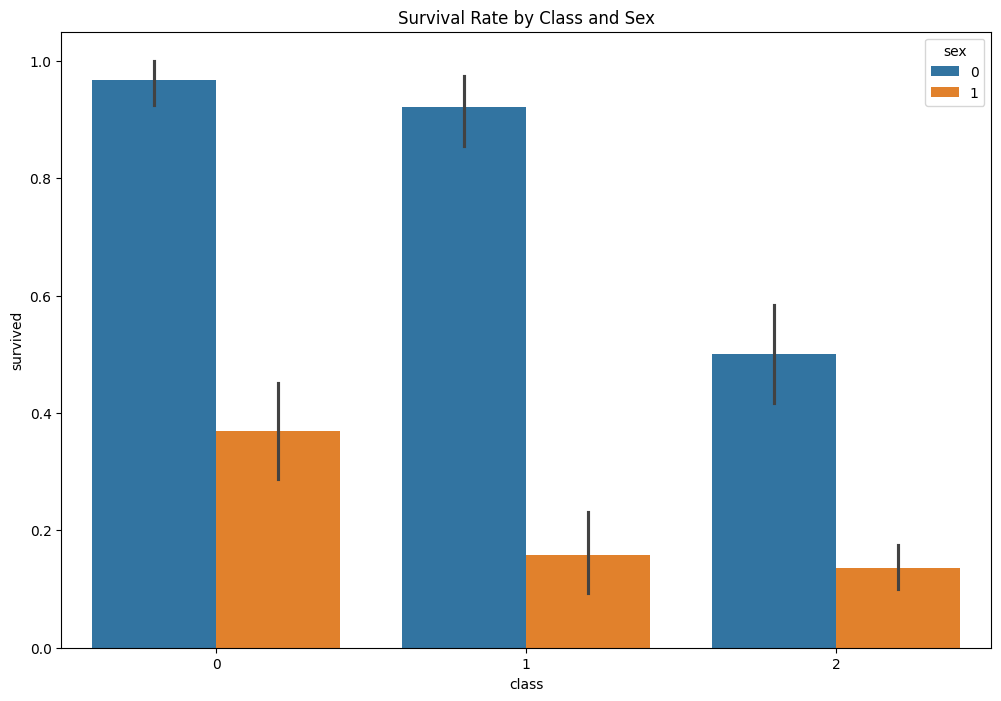

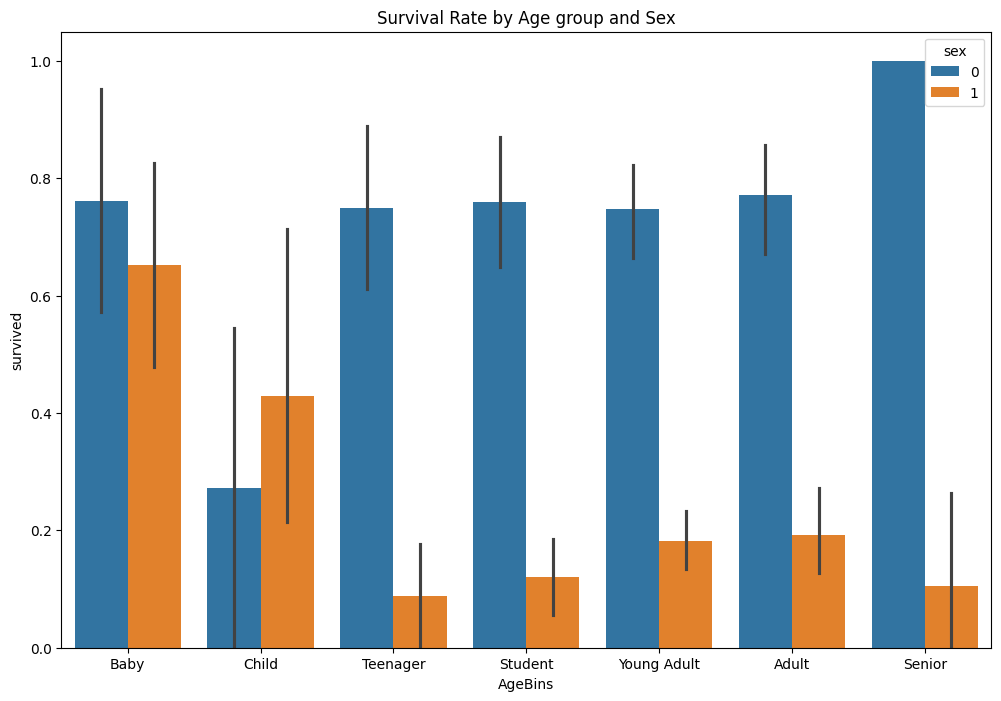

In [78]:
bins = (0, 5, 12, 18, 25, 35, 60, 120)
group_names = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
categories = pd.cut(df.age, bins, labels=group_names)
df['AgeBins'] = categories

plt.figure(figsize=(12, 8))
sns.barplot(x='class', y='survived', hue='sex', data=df)
plt.title('Survival Rate by Class and Sex')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='AgeBins', y='survived', hue='sex', data=df)
plt.title('Survival Rate by Age group and Sex')
plt.show()

df = df.drop(columns=['AgeBins'])

In [80]:
X = df.loc[:, selected_columns]
y = np.ravel(df.loc[:, ['survived']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
for dataset in [X_train, X_test]:
  scaler = preprocessing.StandardScaler().fit(dataset)
  dataset = scaler.transform(dataset)

In [ ]:
for model in [("SVC", SVC(kernel='rbf')), ("KNN", KNeighborsClassifier(n_neighbors=3)), ("RF", RandomForestClassifier(n_estimators=100))]:
  scores = cross_val_score(model[1], X_train, y_train, cv=5, n_jobs=-1)
  model[1].fit(X_train, y_train)
  cv_svm_score = scores.mean()
  print(f"{model[0]} score: ", scores.mean())
  print("Training score: ", model[1].score(X_train, y_train))

  Y_pred = model[1].predict(X_test)
  submission = pd.DataFrame({"Survived": Y_pred})

  y_test_df = pd.DataFrame({"Actual": y_test})
  comparison_df = submission.join(y_test_df.reset_index(drop=True))
  accuracy = accuracy_score(comparison_df['Actual'], comparison_df['Survived'])

  print(f"Accuracy: {accuracy:.2f}\n")


SVC score:  0.6691617102457637
Training score:  0.6691616766467066
Accuracy: 0.67

KNN score:  0.7185613286948715
Training score:  0.842814371257485
Accuracy: 0.72

RF score:  0.790517338121423
Training score:  0.9805389221556886
Accuracy: 0.81



In [ ]:
selected_columns

['pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'who',
 'adult_male',
 'embark_town',
 'alone']

In [ ]:
cols = selected_columns
training = pd.concat([df])

def generateModel():
  kernels = ['SVC', 'KNN', 'RF']
  ind = rnd.randint(0, len(kernels)-1)
  r = kernels[ind]
  return r

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", rnd.randint, 0, 1)
model_types = ['SVC', 'KNN', 'RF']
toolbox.register("attr_model_type", random.choice, model_types)
# features
func_seq = [toolbox.attr_model_type]
for c in cols:
  func_seq.append(toolbox.attr_bool)

toolbox.register("individual", tools.initCycle,
                 creator.Individual, func_seq, 1)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def getModel(individual):
  k = individual[0]
  if k == 'SVC':
    clf = SVC(kernel='rbf')
  elif k == 'KNN':
    clf = KNeighborsClassifier(n_neighbors=3)
  else:
    clf = RandomForestClassifier(n_estimators=100)
  return clf


def getXy(individual):
  scols = list(cols)
  for i in range(len(individual[1:])):
    if individual[1+i] < 1:
      scols.remove(cols[i])
  # print("Selected cols: ",scols)
  tcols = np.append(['survived'], scols)
  df = training.loc[:, tcols].dropna()
  X = df.loc[:, scols]
  scaler = preprocessing.StandardScaler().fit(X)
  # scaler= preprocessing.MinMaxScaler().fit(X)
  X = scaler.transform(X)
  y = np.ravel(df.loc[:, ['survived']])
  return [X, y, scols, scaler]

# the goal ('fitness') function to be maximized


def evalOneMax(individual):
  classifier = getModel(individual)
  Xy = getXy(individual)
  scores = cross_val_score(classifier, Xy[0], Xy[1], cv=5, n_jobs=-1)
  res1 = scores.mean(),
  return res1


def myMutate(individual, indpb=0.05):
  # model
  if rnd.random() < indpb:
    print("mutating model")
    model = generateModel()
    while model == individual[0]:
      model = generateModel()
    print(model)
    individual[0] = model
  # features
  for i in range(len(individual[1:])):
    if rnd.random() < indpb:
      individual[1+i] = toolbox.attr_bool()
  # print(individual)


# ----------
# Operator registration
# ----------
# fitness
toolbox.register("evaluate", evalOneMax)

toolbox.register("mate", tools.cxTwoPoint)

# chance of gene being flipped
toolbox.register("mutate", myMutate, indpb=0.15)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)

rnd.seed(66)

# CXPB  % individuals are crossed
#
# MUTPB % of mutating individual
#
# NGEN  number generations
CXPB, MUTPB, NGEN, POPSIZE = 0.5, 0.2, 40, 100

# create initial population of 300 individuals
pop = toolbox.population(n=POPSIZE)

print("Start of evolution SVM")

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
  ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Begin the evolution
for g in range(NGEN):
  print("-- Generation %i --" % g)

  # Select the next generation individuals
  offspring = toolbox.select(pop, len(pop))
  # Clone the selected individuals
  offspring = list(map(toolbox.clone, offspring))

  # Apply crossover and mutation on the offspring
  # cross individuals
  for child1, child2 in zip(offspring[::2], offspring[1::2]):
    if rnd.random() < CXPB:
      c1 = toolbox.clone(child1)
      c2 = toolbox.clone(child2)
      toolbox.mate(child1, child2)
      # fitness values of the children
      # must be recalculated later
      if c1 != child1:
        del child1.fitness.values
      if c2 != child2:
        del child2.fitness.values

    # mutate individuals
  for mutant in offspring:
    if rnd.random() < MUTPB:
      m1 = toolbox.clone(mutant)
      toolbox.mutate(mutant)
      if m1 != mutant:
        del mutant.fitness.values

  # evaluate new individuals
  invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
  # print(invalid_ind)
  fitnesses = map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  print("  Evaluated %i individuals" % len(invalid_ind))

  # replacing population
  pop[:] = offspring

  # gather all fitness
  fits = [ind.fitness.values[0] for ind in pop]

  length = len(pop)
  mean = sum(fits) / length
  sum2 = sum(x*x for x in fits)
  std = abs(sum2 / length - mean**2)**0.5
  best_ind = tools.selBest(pop, POPSIZE)[0]
  print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
  print("  Min %s" % min(fits))
  print("  Max %s" % max(fits))
  print("  Avg %s" % mean)
  print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, POPSIZE)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


model = getModel(best_ind)
Xy = getXy(best_ind)
newCols = Xy[2]
scaler = Xy[3]
print("Selected Features: ", newCols)

c:\Users\André Knopp Guimarãe\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\André Knopp Guimarãe\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Start of evolution SVM
  Evaluated 100 individuals
-- Generation 0 --
mutating model
SVC
mutating model
KNN
mutating model
SVC
  Evaluated 50 individuals
Best individual is ['SVC', 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0], (0.8350072186303434,)
  Min 0.7105329232314357
  Max 0.8350072186303434
  Avg 0.8119424392693487
  Std 0.020550552555799663
-- Generation 1 --
  Evaluated 52 individuals
Best individual is ['SVC', 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0], (0.835019772770071,)
  Min 0.7845395769254911
  Max 0.835019772770071
  Avg 0.8246710815391374
  Std 0.008868174253866306
-- Generation 2 --
mutating model
RF
mutating model
KNN
mutating model
RF
mutating model
KNN
  Evaluated 43 individuals
Best individual is ['SVC', 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0], (0.835019772770071,)
  Min 0.6812692235264579
  Max 0.835019772770071
  Avg 0.825985625510012
  Std 0.019324685800877532
-- Generation 3 --
mutating model
RF
mutating model
RF
  Evaluated 39 individuals
Best individual is ['SVC', 1, 1, 1, 1, 

In [ ]:
X_train = Xy[0]
Y_train = Xy[1]

scores = cross_val_score(model, X_train, Y_train, cv=5).mean()
cv_SVMGA_score = scores.mean()
print("SVMGA CV score: ", scores.mean())
model.fit(X_train, Y_train)
print("Training score: ", model.score(X_train, Y_train))

SVMGA CV score:  0.8361308141359614
Training score:  0.8361391694725028
